In [2]:
import pandas as pd
import numpy as np
#from keras.models import Sequential,Model
#from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
#from keras.optimizers import Adam
#from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
#from keras.utils import to_categorical
%matplotlib inline

In [3]:
#normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm
#scale back to the true range
def true_range(df, x):
    X = (x * (df['mid1'].max() - df['mid1'].min())) + df['mid1'].min()
    return X
#rolling windows
def train_windows(df, ref_day=10, predict_day=5):
    X_train, Y_train = [], []
    for i in range(int(df.shape[0] / 5 - 2)):
        #扣掉response
        #記得最後一行要放response
        #if i == df.shape[0]-predict_day-ref_day -1:
        #    X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        #    Y_train.append(np.array(df.iloc[i+ref_day:]["mid1"]))
        #else:  
        X_train.append(np.array(df.iloc[i * predict_day: predict_day * (i + 2),:-1]))
        Y_train.append(np.array(df.iloc[(i+2) * predict_day: (i+3) * predict_day]["mid1"]))
    return np.array(X_train), np.array(Y_train)
#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    #10 -> X shape
    model.add(Dense(10,activation='linear'))
    #5 -> Y shape
    model.add(Dense(5,activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.sum(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)

In [5]:
df = pd.read_csv('./data/3406_2.csv')
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
#1 tick
df['da1_dt_1'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt_1'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt_1'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt_1'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt_1'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt_1'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt_1'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt_1'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt_1'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt_1'] = df['Bid5'] - df['Bid5'].shift(1)
#5 ticks
df['da1_dt_5'] = df['Ask1'] - df['Ask1'].shift(5)
df['da2_dt_5'] = df['Ask2'] - df['Ask2'].shift(5)
df['da3_dt_5'] = df['Ask3'] - df['Ask3'].shift(5)
df['da4_dt_5'] = df['Ask4'] - df['Ask4'].shift(5)
df['da5_dt_5'] = df['Ask5'] - df['Ask5'].shift(5)
df['db1_dt_5'] = df['Bid1'] - df['Bid1'].shift(5)
df['db2_dt_5'] = df['Bid2'] - df['Bid2'].shift(5)
df['db3_dt_5'] = df['Bid3'] - df['Bid3'].shift(5)
df['db4_dt_5'] = df['Bid4'] - df['Bid4'].shift(5)
df['db5_dt_5'] = df['Bid5'] - df['Bid5'].shift(5)
##10 ticks
df['da1_dt_10'] = df['Ask1'] - df['Ask1'].shift(10)
df['da2_dt_10'] = df['Ask2'] - df['Ask2'].shift(10)
df['da3_dt_10'] = df['Ask3'] - df['Ask3'].shift(10)
df['da4_dt_10'] = df['Ask4'] - df['Ask4'].shift(10)
df['da5_dt_10'] = df['Ask5'] - df['Ask5'].shift(10)
df['db1_dt_10'] = df['Bid1'] - df['Bid1'].shift(10)
df['db2_dt_10'] = df['Bid2'] - df['Bid2'].shift(10)
df['db3_dt_10'] = df['Bid3'] - df['Bid3'].shift(10)
df['db4_dt_10'] = df['Bid4'] - df['Bid4'].shift(10)
df['db5_dt_10'] = df['Bid5'] - df['Bid5'].shift(10)
#1 tick
df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
#5 ticks
df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
#10 ticks
df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#drop nan
df = df.dropna()
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
#df = df.drop(['b43_diff_abs'], axis = 1)
#df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#3/23 3/24 data有缺值 -> drop
df = df[df['TxTime'] != '2020-03-23']
df = df[df['TxTime'] != '2020-03-24']
df = df.reset_index(drop = True)
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)

In [7]:
train_5t = pd.read_csv('./data/train_5t_2.csv')
test_5t = pd.read_csv('./data/test_5t_2.csv')

In [8]:
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#test
df_test = df.iloc[372025: ]
#為了可以被5整除
df_train = df.iloc[0:372025]
#1~10 pred 11, hence start from 11
df_train = df_train.iloc[10:, :]
df_test = df_test.iloc[10:, :]
#reset index
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [9]:
#calculate pred return
df_train['pred_mid'] = train_5t[['0']]
#df_train['mid_shift'] = df_train['pred_mid'].shift(1)
df_test['pred_mid'] = test_5t[['0']]

In [10]:
df_train['mid_5_shift'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
for i in range(int(int(len(df_train)) / 5)):
    df_train['mid_5_shift'].iloc[5 * i] = df_train['pred_mid'].iloc[(5 * i) + 4]
df_train['pred_return'] = df_train['mid_5_shift'] / df_train['pred_mid'] - 1
for i in range(len(df_train)):
    if df_train['pred_return'].iloc[i] == -1:
        df_train['pred_return'].iloc[i] = 0

In [11]:
df_test['mid_5_shift'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
for i in range(int(int(len(df_test)) / 5)):
    df_test['mid_5_shift'].iloc[5 * i] = df_test['pred_mid'].iloc[(5 * i) + 4]
df_test['pred_return'] = df_test['mid_5_shift'] / df_test['pred_mid'] - 1
for i in range(len(df_test)):
    if df_test['pred_return'].iloc[i] == -1:
        df_test['pred_return'].iloc[i] = 0

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]),
 <a list of 10 Text xticklabel objects>)

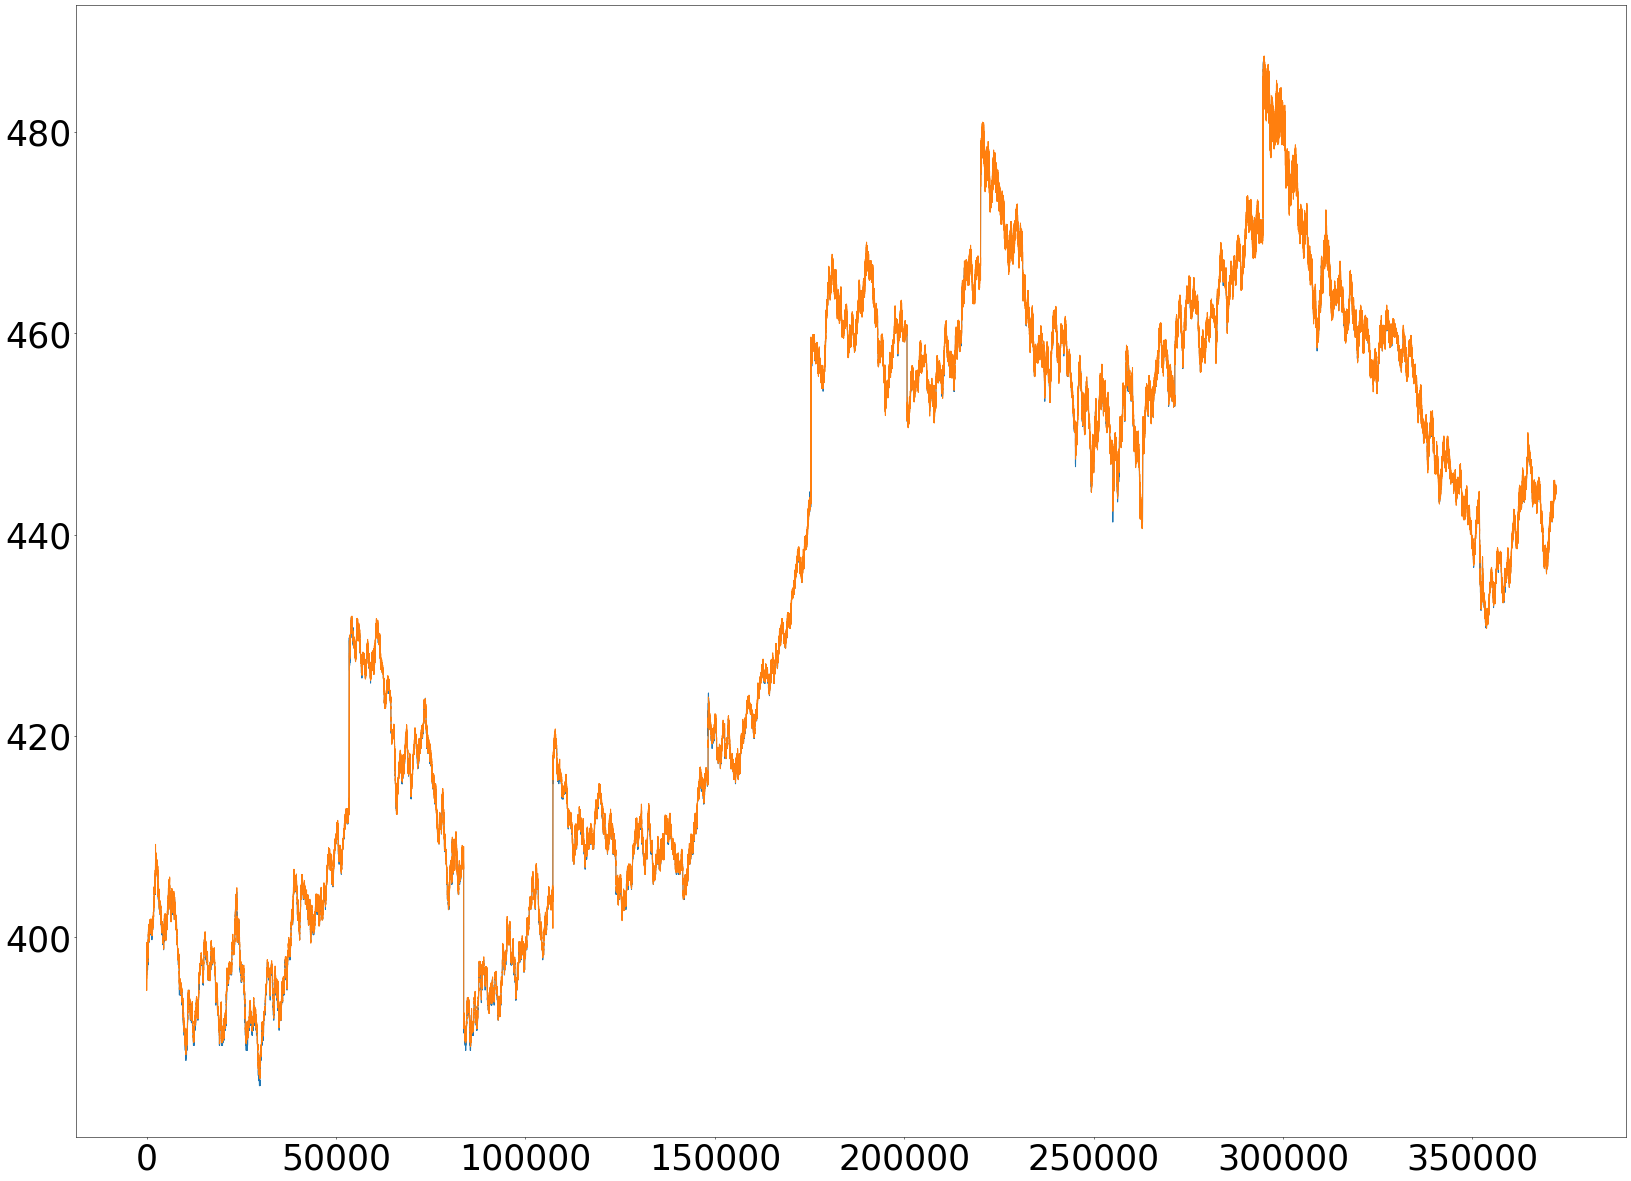

In [23]:
plt.figure(figsize=(40,30),dpi=50)
plt.plot(df_train['mid1'])
plt.plot(df_train['pred_mid'])
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

(array([380., 400., 420., 440., 460., 480., 500.]),
 <a list of 7 Text xticklabel objects>)

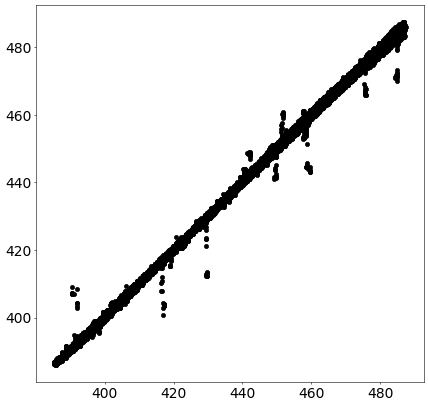

In [27]:
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(df_train['mid1'], df_train['pred_mid'], color = ['black'])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000., 140000.]),
 <a list of 9 Text xticklabel objects>)

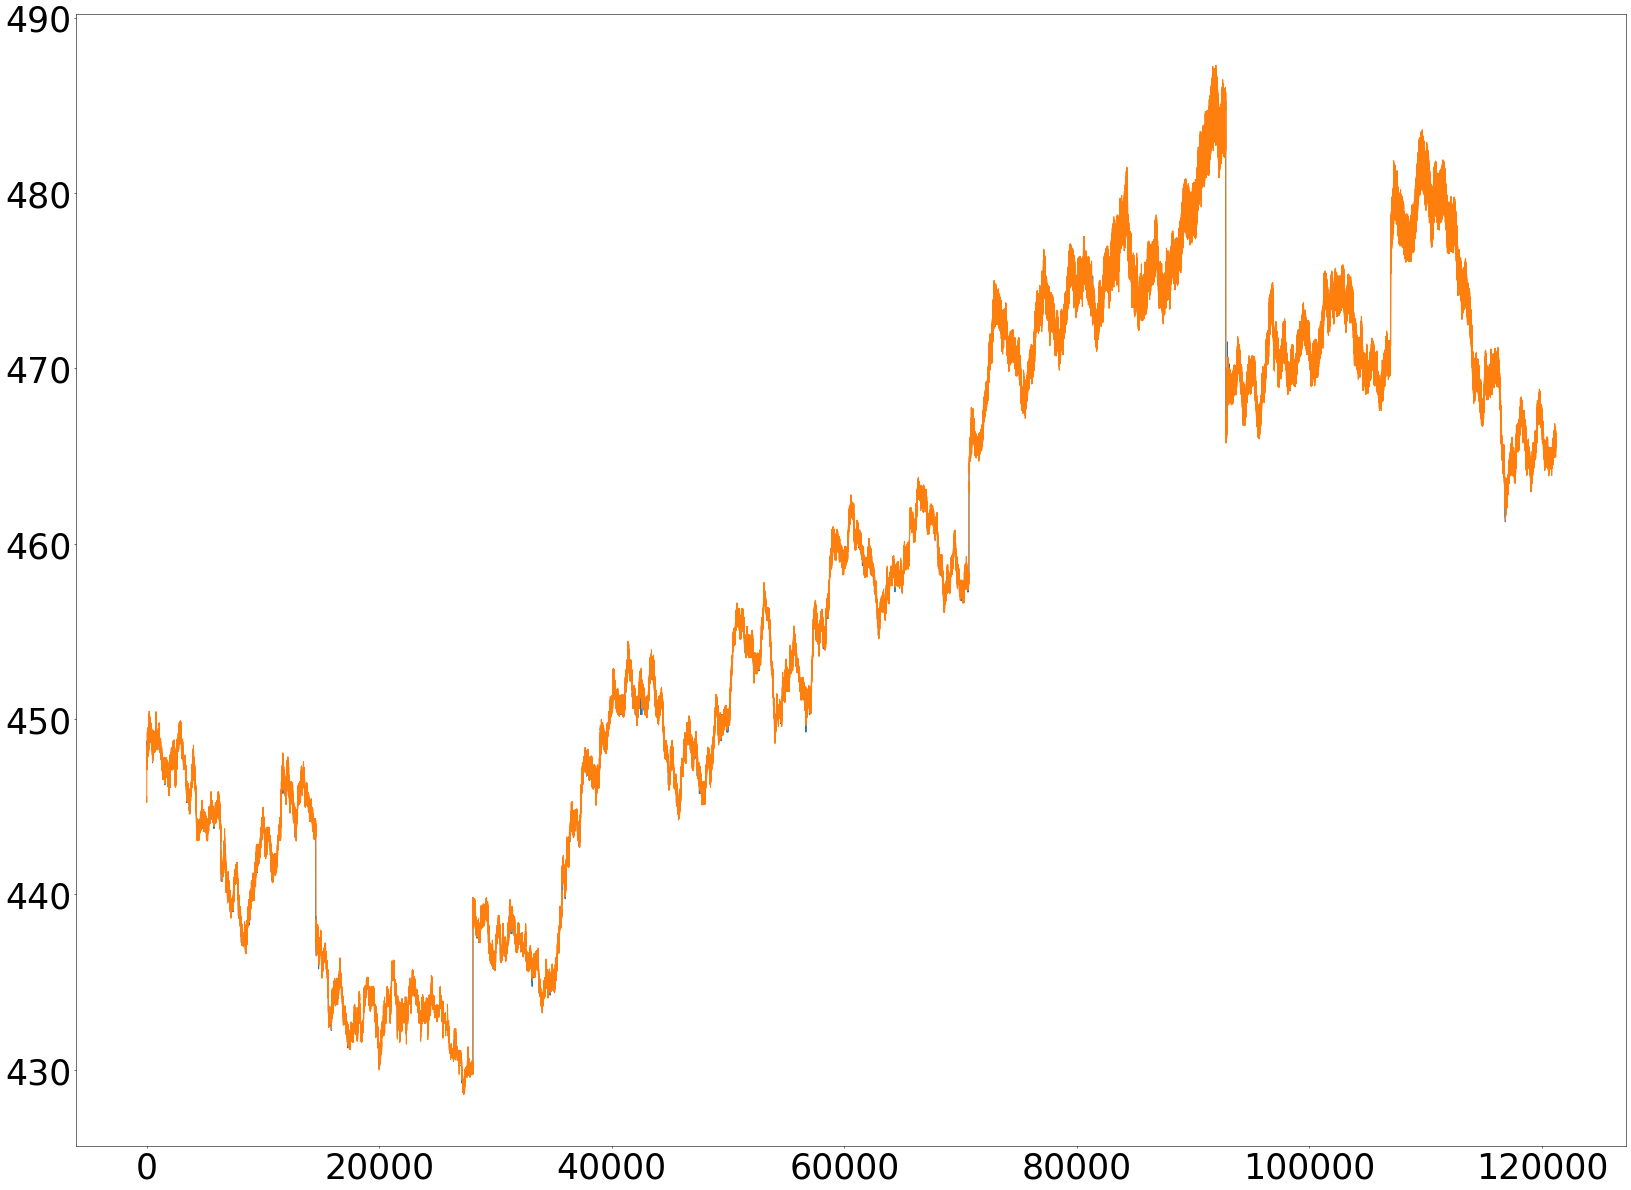

In [22]:
plt.figure(figsize=(40,30),dpi=50)
plt.plot(df_test['mid1'])
plt.plot(df_test['pred_mid'])
plt.yticks(fontsize=50)
plt.xticks(fontsize=50)

(array([420., 430., 440., 450., 460., 470., 480., 490.]),
 <a list of 8 Text xticklabel objects>)

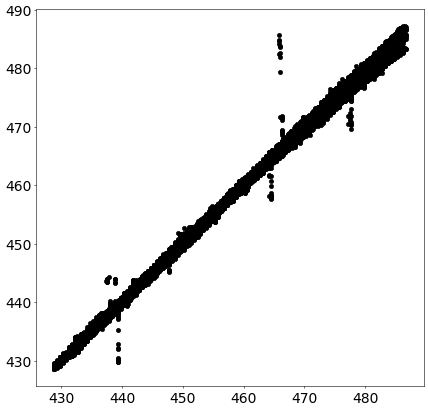

In [26]:
plt.figure(figsize=(10,10),dpi=50)
plt.scatter(df_test['mid1'], df_test['pred_mid'], color = ['black'])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [21]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004], [-0.001, -0.0015, -0.002, -0.0025, -0.003, -0.0035, -0.004], [-0.01, -0.015, -0.02, -0.025]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.001, -0.001, -0.01),
 (0.001, -0.001, -0.015),
 (0.001, -0.001, -0.02),
 (0.001, -0.001, -0.025),
 (0.001, -0.0015, -0.01),
 (0.001, -0.0015, -0.015),
 (0.001, -0.0015, -0.02),
 (0.001, -0.0015, -0.025),
 (0.001, -0.002, -0.01),
 (0.001, -0.002, -0.015),
 (0.001, -0.002, -0.02),
 (0.001, -0.002, -0.025),
 (0.001, -0.0025, -0.01),
 (0.001, -0.0025, -0.015),
 (0.001, -0.0025, -0.02),
 (0.001, -0.0025, -0.025),
 (0.001, -0.003, -0.01),
 (0.001, -0.003, -0.015),
 (0.001, -0.003, -0.02),
 (0.001, -0.003, -0.025),
 (0.001, -0.0035, -0.01),
 (0.001, -0.0035, -0.015),
 (0.001, -0.0035, -0.02),
 (0.001, -0.0035, -0.025),
 (0.001, -0.004, -0.01),
 (0.001, -0.004, -0.015),
 (0.001, -0.004, -0.02),
 (0.001, -0.004, -0.025),
 (0.0015, -0.001, -0.01),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.001, -0.025),
 (0.0015, -0.0015, -0.01),
 (0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.0015, -0.025),
 (0.0015, -0.002, -0.01),
 (0.0015, -0.002, -0.015),
 (0.0

In [13]:
#paras = [(0.0015, -0.002, -0.015), (0.0015, -0.0015, -0.015), (0.0015, -0.0015, -0.01)]

In [22]:
#colab lstm_mid1_5t
#adding hard stop and 1->0 / -1->0 stop
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            #long side
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            #short side
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]) or (df['pred_return'].iloc[i] < - paras[l][0] / 2): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and (((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]) or (df['pred_return'].iloc[i] > - paras[l][1] / 2)): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-pa

In [23]:
equity_value_1.columns = paras
equity_value_1

,"(0.001, -0.001, -0.01)","(0.001, -0.001, -0.015)","(0.001, -0.001, -0.02)","(0.001, -0.001, -0.025)","(0.001, -0.0015, -0.01)","(0.001, -0.0015, -0.015)","(0.001, -0.0015, -0.02)","(0.001, -0.0015, -0.025)","(0.001, -0.002, -0.01)","(0.001, -0.002, -0.015)",...,"(0.004, -0.003, -0.02)","(0.004, -0.003, -0.025)","(0.004, -0.0035, -0.01)","(0.004, -0.0035, -0.015)","(0.004, -0.0035, -0.02)","(0.004, -0.0035, -0.025)","(0.004, -0.004, -0.01)","(0.004, -0.004, -0.015)","(0.004, -0.004, -0.02)","(0.004, -0.004, -0.025)"
0,-0.00150,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.00150,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.00150,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.00150,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.00150,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,-0.001500,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372010,-0.16406,-0.111737,-0.099352,-0.087438,-0.112523,-0.050975,-0.037475,-0.044646,-0.070877,-0.032021,...,0.16791,0.16791,0.093468,0.146963,0.146963,0.146963,0.030586,0.078622,0.074255,0.090631
372011,-0.16406,-0.111737,-0.099352,-0.087438,-0.112523,-0.050975,-0.037475,-0.044646,-0.070877,-0.032021,...,0.16791,0.16791,0.093468,0.146963,0.146963,0.146963,0.030586,0.078622,0.074255,0.090631
372012,-0.16406,-0.111737,-0.099352,-0.087438,-0.112523,-0.050975,-0.037475,-0.044646,-0.070877,-0.032021,...,0.16791,0.16791,0.093468,0.146963,0.146963,0.146963,0.030586,0.078622,0.074255,0.090631
372013,-0.16406,-0.111737,-0.099352,-0.087438,-0.112523,-0.050975,-0.037475,-0.044646,-0.070877,-0.032021,...,0.16791,0.16791,0.093468,0.146963,0.146963,0.146963,0.030586,0.078622,0.074255,0.090631


In [24]:
for i in equity_value_1.iloc[-1].sort_values(ascending=False).index.to_list():
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.003, -0.0025, -0.015)
return: 0.23058992999323447
std: 0.061068423447269905
sharp ratio: 3.6907769559148598
trades: 8.0
odds ratio: 0.875
mdd: 0.00518340611353707
skewness: -1.4395801494456066
(0.003, -0.0025, -0.02)
return: 0.23058992999323447
std: 0.061068423447269905
sharp ratio: 3.6907769559148598
trades: 8.0
odds ratio: 0.875
mdd: 0.00518340611353707
skewness: -1.4395801494456066
(0.003, -0.0025, -0.025)
return: 0.23058992999323447
std: 0.061068423447269905
sharp ratio: 3.6907769559148598
trades: 8.0
odds ratio: 0.875
mdd: 0.00518340611353707
skewness: -1.4395801494456066
(0.002, -0.0025, -0.025)
return: 0.22244453938531134
std: 0.058261282323168705
sharp ratio: 3.7287977662468976
trades: 11.0
odds ratio: 0.8181818181818182
mdd: 0.0052598870056497216
skewness: -0.9072315177104556
(0.002, -0.0025, -0.02)
return: 0.22244453938531134
std: 0.058261282323168705
sharp ratio: 3.7287977662468976
trades: 11.0
odds ratio: 0.8181818181818182
mdd: 0.0052598870056497216
skewness: -0.9072315

odds ratio: 0.5384615384615384
mdd: 0.012979591836734748
skewness: -1.34140779620553
(0.0025, -0.0035, -0.015)
return: 0.15886772088106188
std: 0.052776852100856836
sharp ratio: 2.911649989798597
trades: 7.0
odds ratio: 0.8571428571428571
mdd: 0.0037598870056497202
skewness: -1.5375467484789003
(0.0025, -0.0035, -0.02)
return: 0.15886772088106188
std: 0.052776852100856836
sharp ratio: 2.911649989798597
trades: 7.0
odds ratio: 0.8571428571428571
mdd: 0.0037598870056497202
skewness: -1.5375467484789003
(0.0025, -0.0035, -0.025)
return: 0.15886772088106188
std: 0.052776852100856836
sharp ratio: 2.911649989798597
trades: 7.0
odds ratio: 0.8571428571428571
mdd: 0.0037598870056497202
skewness: -1.5375467484789003
(0.003, -0.002, -0.015)
return: 0.15867258466292145
std: 0.051031314340179254
sharp ratio: 3.0074197901284614
trades: 12.0
odds ratio: 0.5
mdd: 0.030212039309273075
skewness: -1.5559578758563608
(0.0025, -0.003, -0.01)
return: 0.15469809689339753
std: 0.04610773048572515
sharp ratio

return: 0.11931899521404432
std: 0.044152023087909775
sharp ratio: 2.584683265517084
trades: 18.0
odds ratio: 0.4444444444444444
mdd: 0.029684103163364006
skewness: -1.27921929007331
(0.0025, -0.0015, -0.015)
return: 0.11869329445037197
std: 0.04214977042864419
sharp ratio: 2.692619515983035
trades: 17.0
odds ratio: 0.35294117647058826
mdd: 0.039822527572890065
skewness: -1.5211257408252932
(0.002, -0.0015, -0.025)
return: 0.11809720013205066
std: 0.0375322392964013
sharp ratio: 3.0080059769542067
trades: 19.0
odds ratio: 0.42105263157894735
mdd: 0.03146775497853105
skewness: -1.233868893688907
(0.0015, -0.003, -0.01)
return: 0.11799729297525235
std: 0.041017177181193826
sharp ratio: 2.7500013586251706
trades: 25.0
odds ratio: 0.36
mdd: 0.043763057177108156
skewness: -1.259337146303506
(0.0015, -0.0035, -0.025)
return: 0.11721970291239986
std: 0.042475567198682354
sharp ratio: 2.63727385648366
trades: 17.0
odds ratio: 0.47058823529411764
mdd: 0.03405568786281754
skewness: -1.1889005414

mdd: 0.022242358078602587
skewness: -1.596816169989363
(0.004, -0.004, -0.02)
return: 0.07425507682539312
std: 0.028513100769299207
sharp ratio: 2.421871875111756
trades: 4.0
odds ratio: 0.75
mdd: 0.022242358078602587
skewness: -1.596816169989363
(0.002, -0.001, -0.025)
return: 0.07363561615640019
std: 0.029819343272262523
sharp ratio: 2.295007489989154
trades: 25.0
odds ratio: 0.36
mdd: 0.04146290060959906
skewness: -1.2130026814773673
(0.0015, -0.0015, -0.025)
return: 0.07232895849236859
std: 0.03401940565497661
sharp ratio: 1.9732548879068519
trades: 25.0
odds ratio: 0.36
mdd: 0.03455730872359941
skewness: -0.910760205099205
(0.0025, -0.004, -0.01)
return: 0.0708684731717395
std: 0.024574474565344832
sharp ratio: 2.6722228789520424
trades: 8.0
odds ratio: 0.375
mdd: 0.027292302188719864
skewness: -1.8346290445023765
(0.0015, -0.004, -0.02)
return: 0.069536943931993
std: 0.025718448788404735
sharp ratio: 2.501587263731068
trades: 17.0
odds ratio: 0.4117647058823529
mdd: 0.02968410316

mdd: 0.1408968440111138
skewness: -0.5153721757965932
(0.001, -0.002, -0.015)
return: -0.03202076046128369
std: 0.037589657747105334
sharp ratio: -0.9901862025905235
trades: 41.0
odds ratio: 0.36585365853658536
mdd: 0.12722101687963866
skewness: -0.3064184390095954
(0.001, -0.003, -0.025)
return: -0.03332908167383429
std: 0.04094637633200066
sharp ratio: -0.9409643813516851
trades: 34.0
odds ratio: 0.3235294117647059
mdd: 0.14259605999802805
skewness: -0.36976327532531483
(0.001, -0.0015, -0.02)
return: -0.03747487594543101
std: 0.03390570436875933
sharp ratio: -1.2586341071489902
trades: 39.0
odds ratio: 0.3333333333333333
mdd: 0.11659705040946261
skewness: -0.3634140252002924
(0.001, -0.0015, -0.025)
return: -0.04464643994661713
std: 0.035911940036917035
sharp ratio: -1.3880185780934027
trades: 39.0
odds ratio: 0.3333333333333333
mdd: 0.11829626639637685
skewness: -0.17284167693080354
(0.001, -0.0035, -0.015)
return: -0.04525245185806047
std: 0.04083984911705919
sharp ratio: -1.23537

In [53]:
profit_col = []
for i in paras:
    Return, Std, SR, Trades, Odd, Mdd, Sk = performance(equity_value_1[[i]], transaction_history1[i])
    if (Return > 0) and (Trades > 28):
        profit_col.append(i)

return: -0.16406029723171242
std: 0.05190925291009587
sharp ratio: -3.260696075223091
trades: 66.0
odds ratio: 0.25757575757575757
mdd: 0.19748448507339122
skewness: -0.5320888436061672
return: -0.11173733104404007
std: 0.04097701427633991
sharp ratio: -2.8537299046592466
trades: 53.0
odds ratio: 0.33962264150943394
mdd: 0.16106874223059808
skewness: -0.34311659142473483
return: -0.09935169361629279
std: 0.03872872874748149
sharp ratio: -2.699590123342009
trades: 48.0
odds ratio: 0.3125
mdd: 0.15183285908484873
skewness: -0.20783220935200397
return: -0.08743826347914366
std: 0.03802776958553704
sharp ratio: -2.4360688120498244
trades: 47.0
odds ratio: 0.3191489361702128
mdd: 0.1392260534543357
skewness: -0.235940958063348
return: -0.11252287529611213
std: 0.04442785579088681
sharp ratio: -2.6497537007009875
trades: 56.0
odds ratio: 0.25
mdd: 0.16863296039322445
skewness: -0.3858498683920518
return: -0.050974919276219534
std: 0.03519259502533318
sharp ratio: -1.5962141818692925
trades: 

std: 0.04608869110210739
sharp ratio: 3.2111429447103568
trades: 19.0
odds ratio: 0.47368421052631576
mdd: 0.025182816569205235
skewness: -1.2998442595952595
return: 0.14825818548441827
std: 0.04447088387604592
sharp ratio: 3.2168954834170957
trades: 18.0
odds ratio: 0.5
mdd: 0.029684103163364006
skewness: -1.3046098814143745
return: 0.1442293399181691
std: 0.04446085406747074
sharp ratio: 3.127005606036891
trades: 18.0
odds ratio: 0.5
mdd: 0.03405568786281754
skewness: -1.300006498825856
return: 0.08859641767140908
std: 0.03994514693040454
sharp ratio: 2.087773461359615
trades: 25.0
odds ratio: 0.32
mdd: 0.043763057177108156
skewness: -1.2186312731517803
return: 0.1274662691620121
std: 0.04436793742028846
sharp ratio: 2.7557348001961093
trades: 18.0
odds ratio: 0.4444444444444444
mdd: 0.025182816569205235
skewness: -1.218575032891714
return: 0.11931899521404432
std: 0.044152023087909775
sharp ratio: 2.584683265517084
trades: 18.0
odds ratio: 0.4444444444444444
mdd: 0.02968410316336400

return: 0.10913534940855601
std: 0.04043893025481691
sharp ratio: 2.5701804858246886
trades: 17.0
odds ratio: 0.35294117647058826
mdd: 0.04938047261470602
skewness: -1.3947370798103216
return: 0.12302715124806352
std: 0.04282728732840743
sharp ratio: 2.751216773188166
trades: 16.0
odds ratio: 0.375
mdd: 0.0385087432676991
skewness: -1.5421549430468533
return: 0.14156534333150367
std: 0.04762137235790114
sharp ratio: 2.8635324136953075
trades: 13.0
odds ratio: 0.46153846153846156
mdd: 0.033971926314922796
skewness: -1.4892082914117404
return: 0.1367863708105957
std: 0.046485746605047264
sharp ratio: 2.830682099796768
trades: 13.0
odds ratio: 0.46153846153846156
mdd: 0.03875089883583077
skewness: -1.4658764284626589
return: 0.13200739828968772
std: 0.04563477547597221
sharp ratio: 2.7787448709253497
trades: 13.0
odds ratio: 0.46153846153846156
mdd: 0.04352987135673875
skewness: -1.4161708981668135
return: 0.18836592891576825
std: 0.04997437264278081
sharp ratio: 3.6651971646557127
trades

skewness: -0.527692904768361
return: 0.049239410033808995
std: 0.028859586293687532
sharp ratio: 1.5259889585957702
trades: 17.0
odds ratio: 0.23529411764705882
mdd: 0.07464104691644768
skewness: -0.5204117389024654
return: 0.08417679074199069
std: 0.034371935865094655
sharp ratio: 2.297711454250475
trades: 14.0
odds ratio: 0.2857142857142857
mdd: 0.039703666208265986
skewness: -1.498702587189553
return: 0.07939781822108272
std: 0.03357573021024221
sharp ratio: 2.209864618177353
trades: 14.0
odds ratio: 0.2857142857142857
mdd: 0.04448263872917396
skewness: -1.405835219982836
return: 0.07461884570017474
std: 0.033123912774517476
sharp ratio: 2.0957320523310665
trades: 14.0
odds ratio: 0.2857142857142857
mdd: 0.04926161125008194
skewness: -1.2656952140407913
return: 0.08274435379100209
std: 0.031773959238481295
sharp ratio: 2.440500197315306
trades: 12.0
odds ratio: 0.3333333333333333
mdd: 0.0464011405260088
skewness: -1.4600240438016052
return: 0.12966051475002588
std: 0.047699847358462

std: 0.05286778058456916
sharp ratio: 2.6814610095616778
trades: 5.0
odds ratio: 1.0
mdd: 0.0015000000000000013
skewness: -1.4848989353163986
return: 0.1469628922995841
std: 0.05286778058456916
sharp ratio: 2.6814610095616778
trades: 5.0
odds ratio: 1.0
mdd: 0.0015000000000000013
skewness: -1.4848989353163986
return: 0.030585675714678073
std: 0.017179000350183476
sharp ratio: 1.4777155362481234
trades: 4.0
odds ratio: 0.25
mdd: 0.035184699447029566
skewness: -0.28757446962153044
return: 0.07862188905246725
std: 0.02919973864765765
sharp ratio: 2.5144707607976153
trades: 4.0
odds ratio: 0.75
mdd: 0.01787554585152845
skewness: -1.6865012926067946
return: 0.07425507682539312
std: 0.028513100769299207
sharp ratio: 2.421871875111756
trades: 4.0
odds ratio: 0.75
mdd: 0.022242358078602587
skewness: -1.596816169989363
return: 0.09063062267692157
std: 0.0320153057774381
sharp ratio: 2.6684306334855137
trades: 4.0
odds ratio: 0.75
mdd: 0.005866812227074136
skewness: -1.7208000582493446


In [54]:
profit_col

[(0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.001, -0.025),
 (0.0015, -0.0015, -0.01),
 (0.0015, -0.002, -0.01),
 (0.002, -0.001, -0.01),
 (0.0025, -0.001, -0.01)]

In [55]:
for i in profit_col:
    print(i)
    performance(equity_value_1[[i]], transaction_history1[i])

(0.0015, -0.001, -0.015)
return: 0.0363212274839433
std: 0.028710381872888265
sharp ratio: 1.0839712136790365
trades: 34.0
odds ratio: 0.3235294117647059
mdd: 0.04987554380307713
skewness: -0.8543045745794622
(0.0015, -0.001, -0.02)
return: 0.022280575112026316
std: 0.028651398495543035
sharp ratio: 0.5961515321733193
trades: 34.0
odds ratio: 0.3235294117647059
mdd: 0.05663378186753398
skewness: -0.6602508335449411
(0.0015, -0.001, -0.025)
return: 0.03448730442780912
std: 0.02867017992920851
sharp ratio: 1.0215249607824015
trades: 32.0
odds ratio: 0.34375
mdd: 0.042327760250106705
skewness: -0.8661470377119523
(0.0015, -0.0015, -0.01)
return: 0.03077666426397485
std: 0.027646577925460783
sharp ratio: 0.9251294801451839
trades: 36.0
odds ratio: 0.25
mdd: 0.057166428977499684
skewness: -0.7701622989971278
(0.0015, -0.002, -0.01)
return: 0.08000117511180867
std: 0.040431041837263156
sharp ratio: 1.8500926939475593
trades: 29.0
odds ratio: 0.3103448275862069
mdd: 0.03882411829638959
skewne

In [25]:
#profit_col = [(0.0015, -0.002, -0.015), (0.0015, -0.0015, -0.015), (0.0015, -0.0015, -0.01)]

In [50]:
#adding hard stop 
#main strategy (test set)
#record transaction
transaction_history2 = {}
#record equity values
equity_value_2 = pd.DataFrame()
#record each returns
each_return2 = pd.DataFrame()
#record unrealized gain
unrealized_2 = pd.DataFrame()
for l in range(len(profit_col)):
    df_test['side'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
    for j in range(len(df_test)):
        if df_test['pred_return'].iloc[j] > profit_col[l][0]:
            #long side
            df_test['side'].iloc[j] = 1
        elif df_test['pred_return'].iloc[j] < profit_col[l][1]:
            #short side
            df_test['side'].iloc[j] = -1
    date_idx = df_test['TxTime'].unique()
    #紀錄已實現
    equity_value2 = pd.DataFrame()
    #紀錄未實現
    unrealized2 = pd.DataFrame()
    for k in date_idx:
        df = df_test[df_test.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                df['holding'].iloc[i] = 0
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    #stock_price = df['Ask1'].iloc[i]
                    df['equity_value'].iloc[i] = 0
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    #stock_price = df['Bid1'].iloc[i]
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                    transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                    transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    if ((df['mid1'].iloc[i-1] / transaction_history2[profit_col[l]][-1]['Price'] - 1) < profit_col[l][2]) or (df['pred_return'].iloc[i] < - profit_col[l][0] / 2):#or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side 1 -2 -> -1
                    elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history2)
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    if (df['Ask1'].iloc[i] != 0) and (((df['mid1'].iloc[i-1] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1) < profit_col[l][2]) or (df['pred_return'].iloc[i] > - profit_col[l][1] / 2)): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    #change side -1 +2 -> 1
                    elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[profit_col[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        #df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history2 = record_transaction(profit_col[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history2 = record_transaction(profit_col[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value2 = pd.concat([equity_value2, df[['equity_value']]])
        unrealized2 = pd.concat([unrealized2, df['unrealized']])
    #concat
    equity_value_2 = pd.concat([equity_value_2, np.cumsum(equity_value2)], axis = 1)
    each_return2 = pd.concat([each_return2, equity_value2], axis = 1)
    unrealized_2 = pd.concat([unrealized_2, unrealized2], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

In [51]:
equity_value_2.columns = profit_col
equity_value_2

,"(0.002, -0.0025, -0.015)","(0.002, -0.0025, -0.02)","(0.002, -0.0025, -0.025)","(0.003, -0.0025, -0.015)","(0.003, -0.0025, -0.02)","(0.003, -0.0025, -0.025)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
121180,-0.036715,-0.033379,-0.026524,-0.000293,-0.005529,-0.010764
121181,-0.036715,-0.033379,-0.026524,-0.000293,-0.005529,-0.010764
121182,-0.036715,-0.033379,-0.026524,-0.000293,-0.005529,-0.010764
121183,-0.036715,-0.033379,-0.026524,-0.000293,-0.005529,-0.010764


In [52]:
for i in equity_value_2.iloc[-1].sort_values(ascending=False).index.to_list():
    print(i)
    performance(equity_value_2[[i]], transaction_history2[i])

(0.003, -0.0025, -0.015)
return: -0.00029312686778409924
std: 0.007173740745961248
sharp ratio: -0.7657269843319443
trades: 3.0
odds ratio: 0.3333333333333333
mdd: 0.017206806282722475
skewness: 1.6168163312534312
(0.003, -0.0025, -0.02)
return: -0.005528728962024998
std: 0.007438422812509137
sharp ratio: -1.4423392206184593
trades: 3.0
odds ratio: 0.3333333333333333
mdd: 0.022442408376963374
skewness: 1.5294003776888363
(0.003, -0.0025, -0.025)
return: -0.010764331056265786
std: 0.007873209502622575
sharp ratio: -2.0276776644833405
trades: 3.0
odds ratio: 0.3333333333333333
mdd: 0.027678010471204162
skewness: 1.2492613155284014
(0.002, -0.0025, -0.025)
return: -0.026948522966248386
std: 0.01620515078861604
sharp ratio: -1.9838459626572813
trades: 10.0
odds ratio: 0.4
mdd: 0.044114245950294784
skewness: 0.4878281531006158
(0.002, -0.0025, -0.015)
return: -0.03281507631373087
std: 0.016393572872934675
sharp ratio: -2.318901230889862
trades: 11.0
odds ratio: 0.45454545454545453
mdd: 0.04